# Here we demonstrate usefulness of matrix completion in 16S rRNA studies is demonstrated through three separate studies of varying size. 

# These Data sets were chosen for being previously described as machine learning challenge data sets. 

## [Source of data set selection](http://onlinelibrary.wiley.com/doi/10.1111/j.1574-6976.2010.00251.x/full)

## 88 Soils (case study also included)

### P.I. Noah Fierer (University of Colorado) (Lauber et al.)
### [Data and Source](https://qiita.ucsd.edu/study/description/103)

## Fierer  

### P.I. Noah Fierer (University of Colorado) (Fierer et al.) 
### [Data and Source](https://qiita.ucsd.edu/study/description/232)

# Import libraries

In [1]:
from __future__ import division
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from DIECODE import untangle,fetch

Using TensorFlow backend.



## Machine learning on 16S data is hard due to the very high number of zeros in 16S rRNA OTU tables. This is also referred to as a low-density data set.

### To overcome this problem we use matrix completion

#### Matrix completion is a method where unknown values can be approximated using the known data. This prevents the low-density in OTU tables.

#### source


Emmanuel J. Candès , Xiaodong Li , Yi Ma , John Wright, Robust principal component analysis?, Journal of the ACM (JACM), v.58 n.3, p.1-37, May 2011 http://statweb.stanford.edu/~candes/papers/RobustPCA.pdf


### This allows you to view the underlying trends in the data

<img src="etc/decomp.png">

### Impute the unknown values in the data using SoftImpute from FancyImpute 

##### soft Impute
[softImpute](https://web.stanford.edu/~hastie/swData/softImpute/vignette.html)

##### Fancy Impute
[ Fancy Impute](https://github.com/hammerlab/fancyimpute)


# Comparing low-rank completed matrix to original matrix run on machine learning state of the art Random Forests

### Cross-validation is done through an taking the mean score of 20 iteration of splitting (80:20,train:test) and learning.

# Benchmarking Machine Learning Results: 

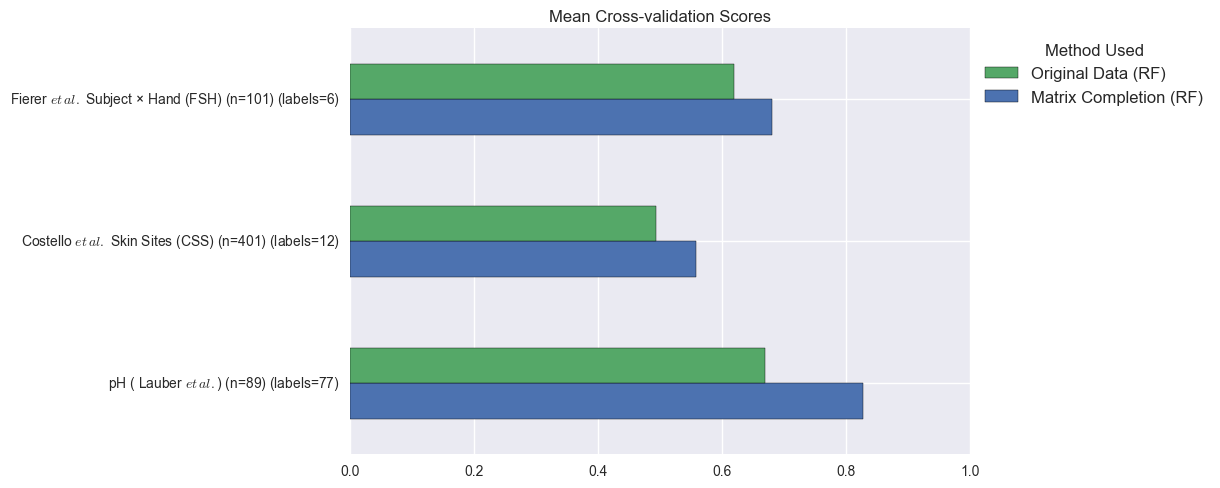

In [36]:
files_to_run={'data/benchmarking/FSH_labels.txt':'data/benchmarking/FSH_otus.txt','data/benchmarking/CSS_labels.txt':'data/benchmarking/CSS_otus.txt','data/benchmarking/88_soils.txt':'data/benchmarking/88_soils.biom'}
scoredfs=[]
otudfs={}
mappings={}
taxaindex={}
for map_file,in_biom in files_to_run.items():    
    otutabledf,mappingdf,taxnames=fetch.dfimport(in_biom,map_file)
    taxaindex[str(map_file.split('/')[-1].split('_')[0])]=taxnames
    otudfs[str(map_file.split('/')[-1].split('_')[0])]=otutabledf #save output
    mappings[str(map_file.split('/')[-1].split('_')[0])]=mappingdf #save output
    scorescomplete,low_rank_data=untangle.machine_learning(otutabledf,mappingdf.T,complete=True,iteration=200,mean_count=20)
    scoresorg,low_rank_data=untangle.machine_learning(otutabledf,mappingdf.T,complete=False,iteration=200,mean_count=20)
    dftest=pd.concat([scorescomplete,scoresorg],axis=1)
    dftest.columns=['Matrix Completion (RF)','Original Data (RF)']
    scoredfs.append(dftest)    
#visualize the results
fig, (ax1) = plt.subplots(ncols=1, nrows=1,sharey=True)
plt.title('Mean Cross-validation Scores')
score_plot=pd.concat(scoredfs).T[['pH (n=89) (labels=77)','label (n=401) (labels=12)','label (n=101) (labels=6)']]
score_plot.columns=['pH ( Lauber $et \, al.$) (n=89) (labels=77)','Costello $et\,al.$ Skin Sites (CSS) (n=401) (labels=12)','Fierer $et\,al.$ Subject × Hand (FSH) (n=101) (labels=6)']
score_plot.T.plot(kind='barh',xlim=(0.,1),ax=ax1)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],loc=2,prop={'size':12}, bbox_to_anchor=(1.0, 1.0),title='Method Used')
plt.show()

# As we expected the machine learning improves for all of the tasks



# Comparing PCoA between completed and non-completed OTU tables

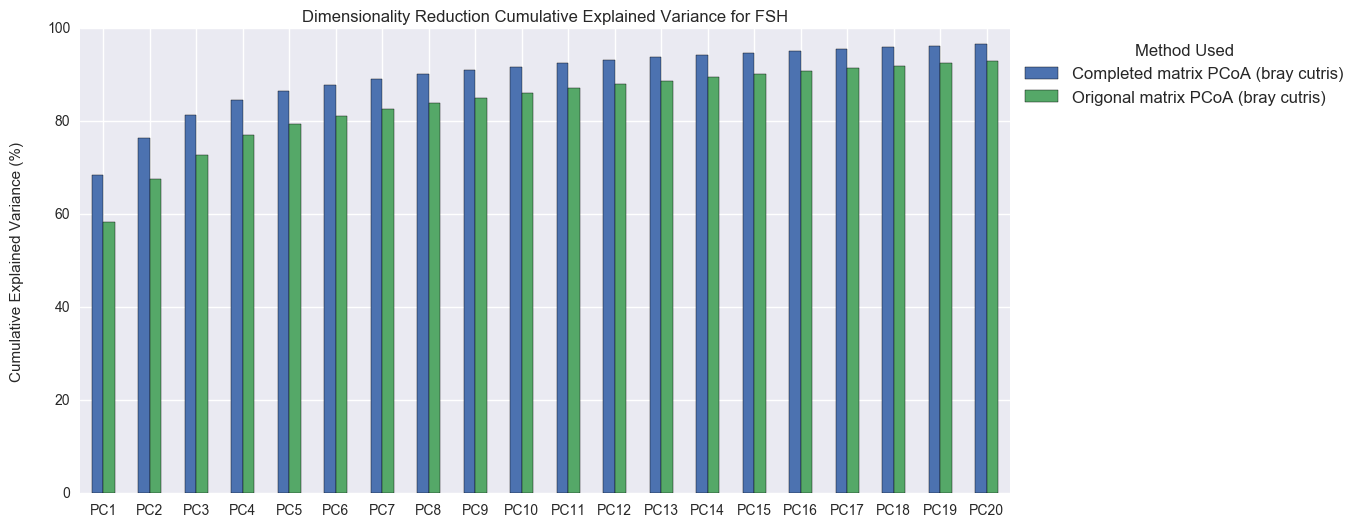

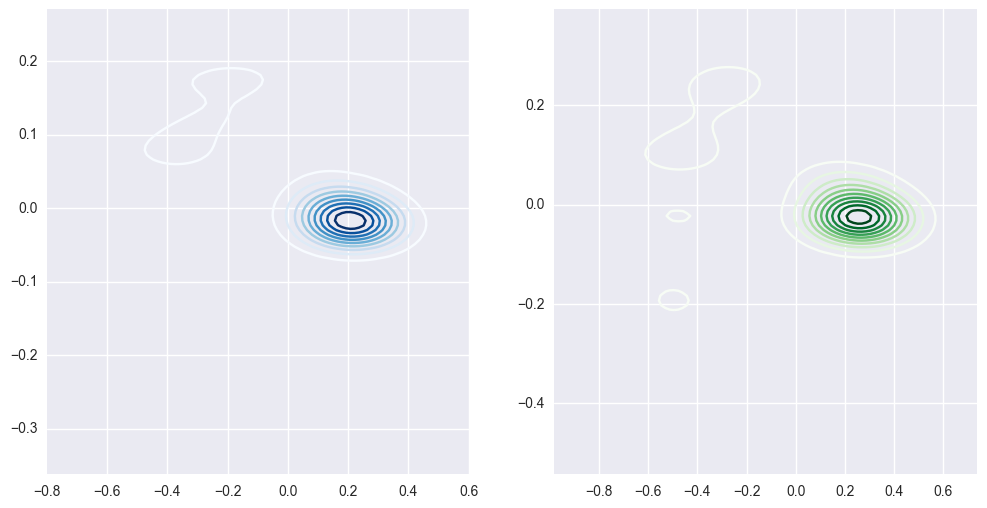

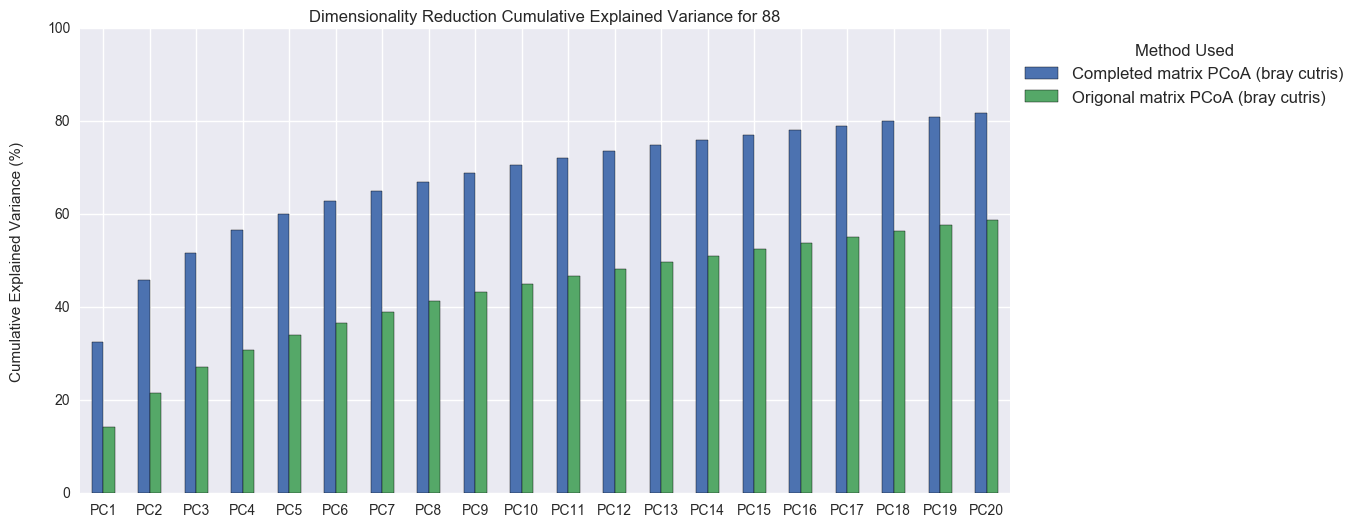

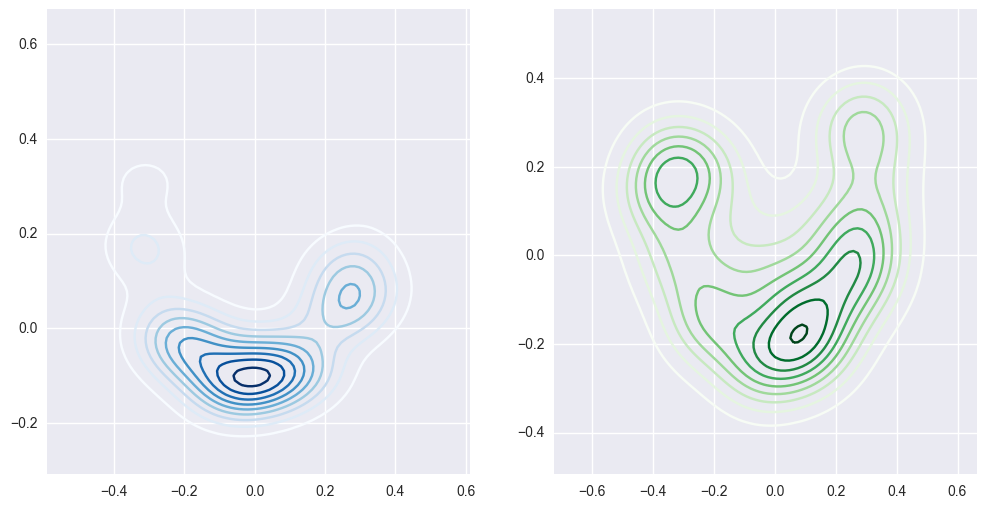

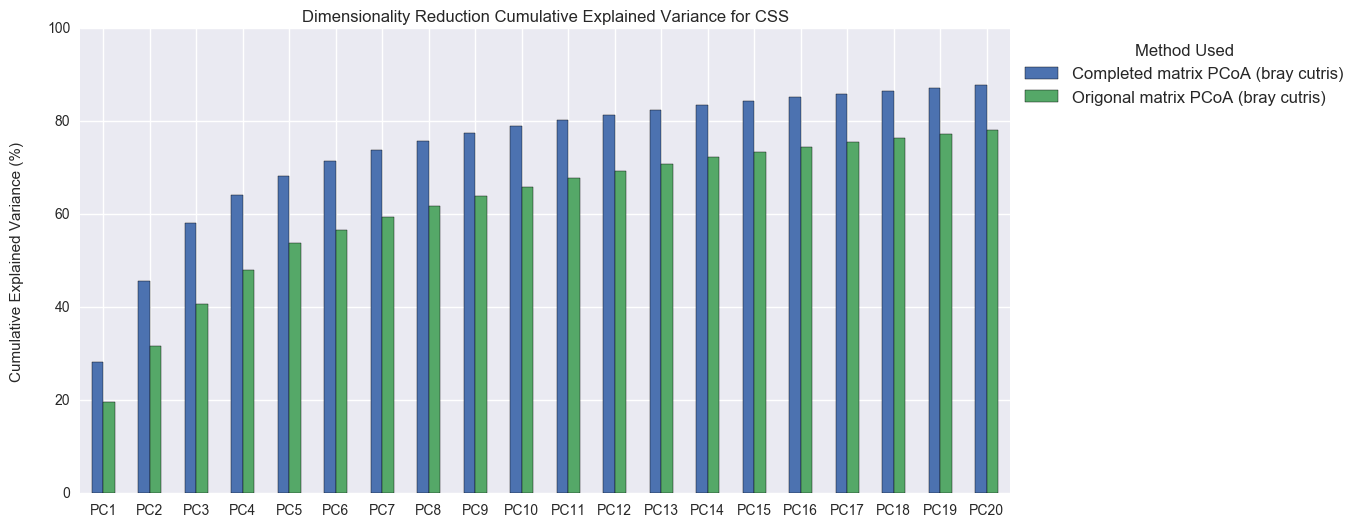

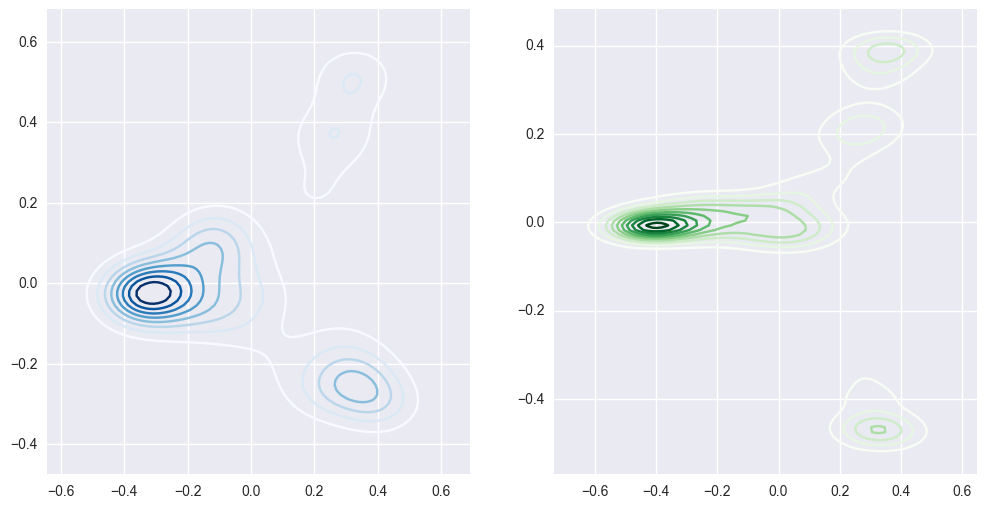

In [37]:
for study,otudf in otudfs.items():
    #intialize to save
    pcoa_lr=[]
    pcoa_org=[]
    n_comp=20
    #pcoa lr
    ord_results=untangle.reduction(untangle.complete_matrix(otudf.as_matrix(),iteration=200).T,list(otudf.columns))
    var_exp=list(ord_results.proportion_explained.values)[:n_comp]
    pcoa_lr=np.cumsum(list(ord_results.proportion_explained.values)[:n_comp])
    pcoalrdf=ord_results.samples[['PC1','PC2']]
    #pcoa org data  
    ord_results=untangle.reduction(otudf.T,list(otudf.columns))
    var_exp=list(ord_results.proportion_explained.values)[:n_comp]
    pcoa_org=np.cumsum(list(ord_results.proportion_explained.values)[:n_comp])
    pcoaorgdf=ord_results.samples[['PC1','PC2']]
    #dataframe to plot
    exp_var_score={'Completed matrix PCoA (bray cutris)':pcoa_lr,'Origonal matrix PCoA (bray cutris)':pcoa_org}
    exp_var_score_pd = pd.DataFrame(exp_var_score)
    exp_var_score_pd.index=["PC"+str(x) for x in range(1,n_comp+1)]
    #plot
    fig, (ax1) = plt.subplots(ncols=1, nrows=1,figsize=(12,6))
    exp_var_score_pd=exp_var_score_pd*100
    exp_var_score_pd.plot(kind='bar',title='Dimensionality Reduction Cumulative Explained Variance for %s'%(study),ylim=(0,100),rot=0,ax=ax1)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, loc=2,prop={'size':12}, bbox_to_anchor=(1.0, 1.0),title='Method Used')
    ax1.set_ylabel('Cumulative Explained Variance (%)\n')
    plt.show()
    fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1,figsize=(12,6))
    sns.kdeplot(np.array(list(pcoalrdf["PC1"])), np.array(list(pcoalrdf["PC2"])),cmap="Blues",shade_lowest=False,ax=ax1)
    sns.kdeplot(np.array(list(pcoaorgdf["PC1"])), np.array(list(pcoaorgdf["PC2"])),cmap="Greens",shade_lowest=False,ax=ax2)
    plt.show()

# Case Study 1

# 88 Soils Case Study

## The 88 soils data set has a well-known gradient along pH, it is composed of 89 soil samples. 

# Supervised machine learning will allow us to identify complex patterns in our OTU table that correlate with mapping data categories such as environmental factors or patient outcomes. 

In [32]:
#this command will do machine leanring on your otu table and mapping file. It ouputs your scores
# complete will determine if you do completion (iteration is the number of iterations for the completion)
soilsscores,soil_low_rank_data=untangle.machine_learning(otudfs['88'],mappings['88'].T,complete=True,iteration=26,mean_count=1)

## Now we can visualize the output of the machine learning.

## The cross-validation scores give you a metric of some of the mapping categories that are most correlated to the patterns in your data. Here we see if the infant is eating pH is an important category.

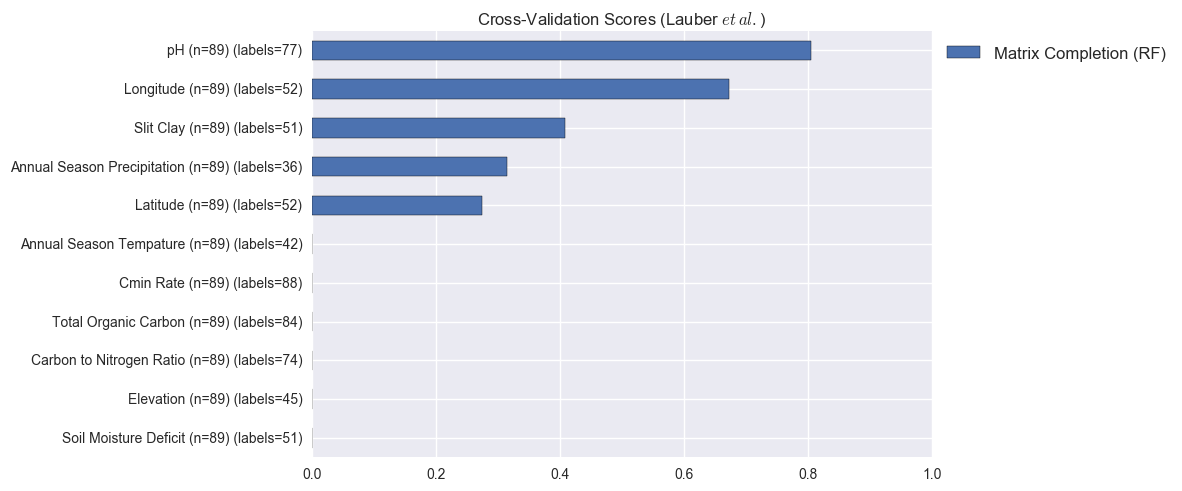

In [30]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1)
soilsscores.columns=['Matrix Completion (RF)']
soilsscores.sort_values(['Matrix Completion (RF)'], ascending = [True], inplace = True)
#rename a few
soilsscores.plot(kind='barh',title='Cross-Validation Scores (Lauber $et \, al.$)',xlim=(0,1),ax=ax1)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],loc=2,prop={'size':12}, bbox_to_anchor=(1.0, 1.0))
ax1.set_ylabel('')
plt.show()

# Machine Learning Extract Important OTUs (features) for pH

### Now that you know pH is an important category you would like to find out what pattern of OTUs best explain that change at each point in your mapping data. Here we plot the pattern that the machine learning found at each pH. The taxonomy labels are the lowest classification assigned with the phylum in parenthesis.


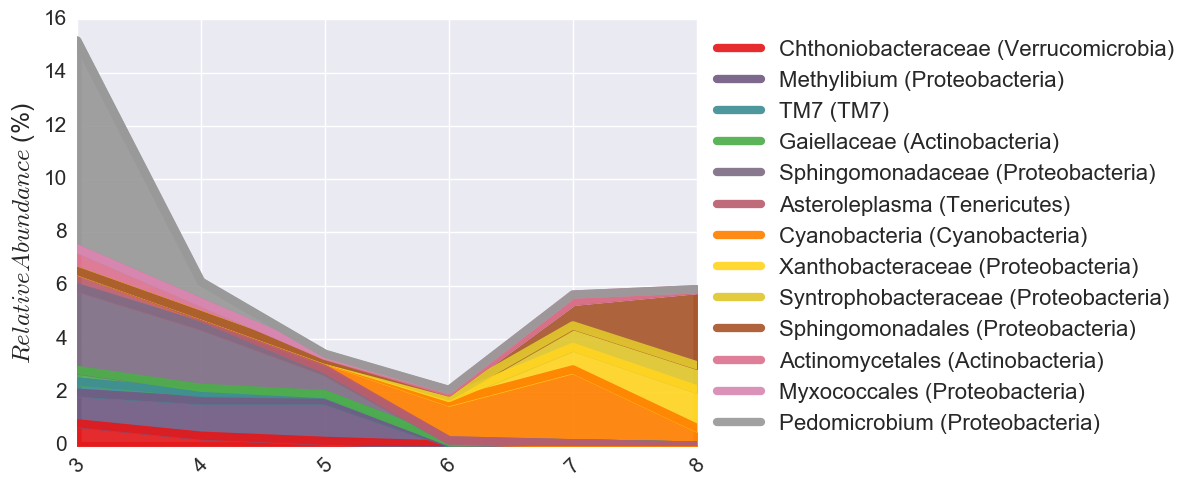

In [33]:
# get important features
n=13 #this will tell the command how many bacteria to plot
niche='pH' #this is a mapping file catagory you would like to plot
# complete will determine if you do completion (iteration is the number of iterations for the completion)
important_otus=untangle.features_ml(otudfs['88'],mappings['88'].T,niche,complete=True,iteration=100)
#plot
fig=untangle.feature_vis(otudfs['88'],mappings['88'],list(important_otus.index[:n]),niche,taxaindex['88'])
plt.show()

# Now that we have very dense data (meaning almost no zeros) we can use previously restricted methods such as PCA. The motivation to using PCA is that we can extract biological knowledge about the axis in PCA that cannot be done in PCoA.

# Example: Learning Bacteria that Cause Variance Along Axis for pH

#### Recovering information about features from PCA eigenvectors  


### Suppose we would like to see how the bacteria change along this first axis of pH since our machine learning identified that as the best category from the metadata.

### If the gradient change is along that axis we can then say what bacteria changes the most along that axis.

### The principal components are a linear combination of original features in N dimensional space

### $ PC^{j} = \beta_{1}^{j}X_{1} +  \beta_{2}^{j}X_{2} + ... + \beta_{N}^{j}X_{N} $

#### Where $\beta_{N}^{j}$ are weights and $X_{N}$ is the original variables

#### Therefore the coefficients are the transform of an identity matrix of shape X

#### Each column of the transformed coefficient matrix are the coefficients $\beta_{N}^{j}$ weights pertaining to each principal component $ PC^{j}$. 

#### In other words we can examine the weights on each OTU or bacteria that best explain the variance of each axis in our PCA graph. 

# Now we can view the gradient for pH through PCA

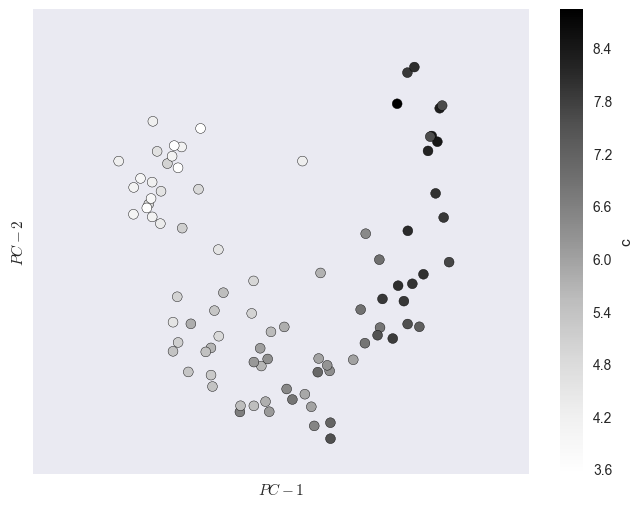

In [7]:
fig,OTUweightsPC1,OTUweightsPC2=untangle.pca_plot(otudfs['88'],mappings['88'],'pH')
plt.show()

# It looks like the data has a strong gradient along the axis $PC-1$ but why? We can say using PCA because we can extract the variant bacteria along that axis. This tells us why there is a gradient in the data. Since the variance is along $PC-1$ we will use the data frame OTUweightsPC1

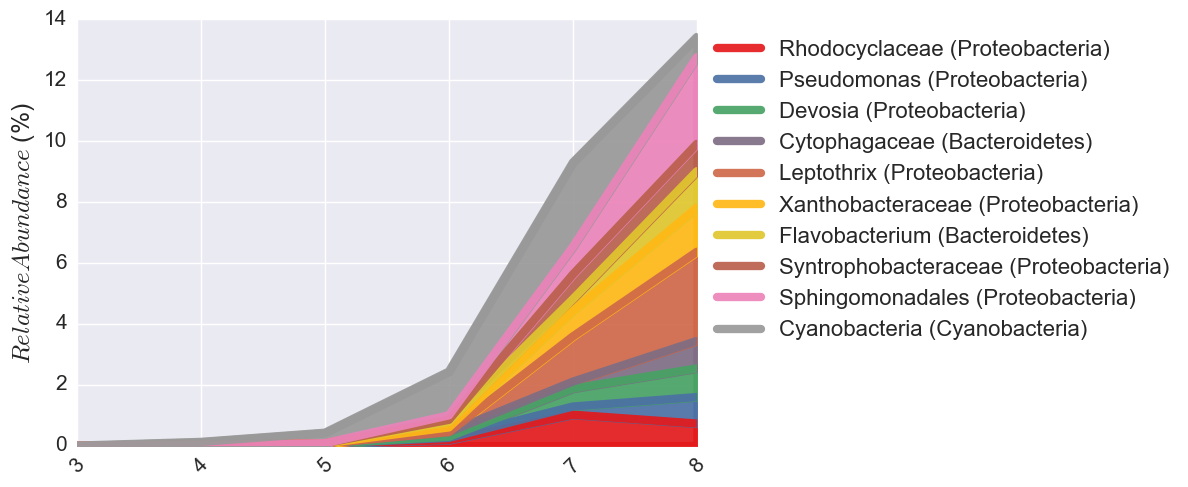

In [35]:
#plot
n=10 #this will tell the command how many bacteria to plot
fig=untangle.feature_vis(otudfs['88'],mappings['88'],list(OTUweightsPC1.index[:n]),niche,taxaindex['88'])
plt.show()

## The Bacteria with the highest variance between pH clusters by multivariate weights make sense because they belong to the families Bradyrhizobiaceae, Sinobacteraceae and Acidobacteriaceae. All of which have members that are described to grow at pH as low as 3 (B. elkanii (Jordan, 1982) and A. capsulatum (Hrash and Coates, 2011)), and pH 5 (S. flavus (Zhou et al., 2008)).

# This not only matches the papers conclustions where this data came from 

http://aem.asm.org/content/75/15/5111.full

# It also makes Biological sense



In [19]:
plt.close('all')